/Users/tomas/thesis/.venv/lib/python3.12/site-packages/crdb/mpl.py:52: RuntimeWarning: table contains potentially incompatbile e_types {np.str_('ETOT'), np.str_('EK')}
  warnings.warn(msg, RuntimeWarning)


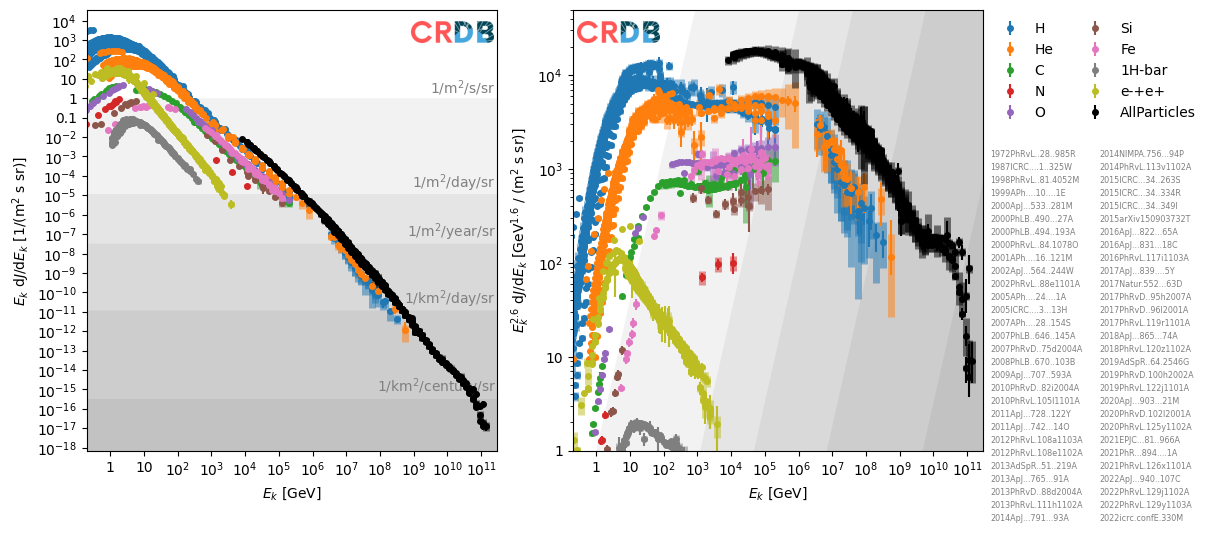

In [4]:
import crdb
from crdb.mpl import draw_references, draw_table, draw_logo
from crdb.experimental import convert_energy
from crdb.units import TeV
import matplotlib.pyplot as plt
from matplotlib import cycler, colors as mcolors
from matplotlib.ticker import MultipleLocator, LogLocator
import numpy as np
from iminuit import Minuit
from iminuit.cost import LeastSquares

cc = (
    # standard markers for our plots
    cycler(marker=["o", "s", "D", "v", "^", "<", ">"])
    * cycler(color=mcolors.TABLEAU_COLORS)
)

plt.rcParams["lines.markersize"] = 5
plt.rcParams["axes.prop_cycle"] = cc
plt.rcParams["figure.constrained_layout.use"] = True


def format_ten_power(val, _):
    x = np.log10(val)
    if abs(x) < 2:
        return f"{val:g}"
    return f"$10^{{{x:g}}}$"


savefig = True  # set to true to save all the plots below as svg and pdf

elements = ("H", "He", "C", "N", "O", "Si", "Fe")
elements += ("1H-bar", "e-+e+", "AllParticles")

tabs = []
for energy_type in ("EKN", "ETOT"):
    for elem in elements:
        tab = crdb.query(
            elem,
            energy_type=energy_type,
            energy_convert_level=1,
        )
        if energy_type == "EKN":
            tab = convert_energy(tab, "EK")
        tabs.append(tab)
tab = np.concatenate(tabs).view(np.recarray)

with np.errstate(divide="ignore"):
    mask = (tab.err_sys[:, 0] > 0) & (tab.err_sta[:, 0] / tab.value < 0.5)
tab = tab[mask]

exponents = (1, 2.6)

fig, ax = plt.subplots(1, 2, sharex=True, figsize=(12, 5))
for expo, axi in zip(exponents, ax):
    plt.sca(axi)
    for elem in elements:
        ma = tab.quantity == elem
        t = tab[ma]
        if len(t) == 0:
            continue
        f = t.e**expo
        color = "k" if elem == "AllParticles" else None
        draw_table(t, factor=f, color=color, label=elem, ms=4)
        if expo == 1:
            plt.ylabel(r"$E_k$ d$J$/d$E_k$ [1/(m$^2$ s sr)]")
        else:
            plt.ylabel(
                f"$E_k^{{{expo}}}$ d$J$/d$E_k$ "
                f"[GeV$^{{{expo - 1}}}$ / (m$^2$ s sr)]"
            )

m = 1
km = 1e3 * m
s = 1
sr = 1
hour = 60**2 * s
day = 24 * hour
month = 30 * day
year = 356 * day
century = 100 * year
x = np.geomspace(2e-1, 3e11, 1000)
for exponent, axi in zip(exponents, ax):
    axi.loglog()
    axi.set_xlabel("$E_k$ [GeV]")
    axi.set_xlim(x[0], x[-1])
    for flux_ref in (
        "1/m^2/s/sr",
        "1/m^2/day/sr",
        "1/m^2/year/sr",
        "1/km^2/day/sr",
        "1/km^2/century/sr",
    ):
        v = eval(flux_ref.replace("^2", "**2"))
        label = flux_ref.replace("^2", "$^2$")
        y = v * x ** (exponent - 1)
        axi.fill_between(x, y, color="k", zorder=0, alpha=0.05, lw=0)
        if axi is ax[0]:
            axi.text(
                x[-1] * 0.9,
                y[-1] * 1.1,
                label,
                va="bottom",
                ha="right",
                color="0.5",
                zorder=0,
            )

ax[1].legend(frameon=False, ncol=2, loc="upper left", bbox_to_anchor=(1, 1))
ax[1].set_ylim(1, 5e4)
draw_references(tab, bbox_to_anchor=(1, 0.7), ncol=2, loc="upper left")
plt.sca(ax[0])
ax[0].xaxis.set_major_locator(LogLocator(numticks=100))
ax[0].xaxis.set_major_formatter(format_ten_power)
ax[0].yaxis.set_major_locator(LogLocator(numticks=100))
ax[0].yaxis.set_major_formatter(format_ten_power)
ax[1].yaxis.set_major_formatter(format_ten_power)
draw_logo(0.78, 1)
plt.sca(ax[1])
draw_logo(0, 1)
if savefig:
    plt.savefig("../figures/cp_fluxes.png", dpi=600)
    plt.savefig("../figures/cp_fluxes.pdf")